# Load H5/NC files directly into tensorflow

The dataset is to large to load into memory directly. Therefor we will define a generator first that can be used to get a part of the dataset

In [65]:
import h5py
import tensorflow as tf
import numpy as np
from datetime import datetime, timedelta
import netCDF4 

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

## Masking the output

The output shape is 765 by 700. However a large part of these pixels are masked and do no contribute to the final image.
The networks output should be masked in order to make comparision to the target output

In [66]:
def get_mask_x():
    # Get the mask for the input data
    x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar'
    # The mask is the same for all radar scans, so simply chose a random one to get the mask
    path = x_path + '/RAD_NL25_RAC_RT_201901010000.h5'

    with h5py.File(path, 'r') as f:
        rain = f['image1']['image_data'][:]
        mask= (rain == 65535)
    return ~ mask

In [67]:
def get_mask_y():
    # Get the mask for the input data
    y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'
    # The mask is the same for all radar scans, so simply chose a random one to get the mask
    path = y_path + '/RAD_NL25_RAC_MFBS_EM_5min_201901010000.nc'

    with netCDF4.Dataset(path, 'r') as f:
        rain = f['image1_image_data'][:]
        mask = (rain == 65535)
    return ~ mask.mask[0]

In [68]:
def get_rain():
    # Get the mask for the input data
    y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'
    path = y_path + '/RAD_NL25_RAC_MFBS_EM_5min_201901010000.nc'

    with netCDF4.Dataset(path, 'r') as f:
        rain = f['image1_image_data'][:].data[0]
        rain[rain == 65535] = 0
        # Expand dimensions from (w,h) to (w,h,c)
        rain = np.expand_dims(rain, axis=-1)
    return rain

[0.   0.01]
(765, 700, 1)


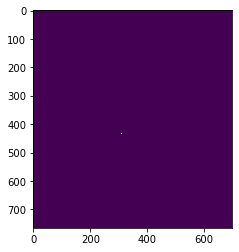

In [69]:
rr = get_rain()
plt.imshow(np.squeeze(rr))
print(np.unique(rr))
print(rr.shape)

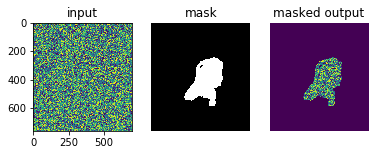

In [70]:
mask = get_mask_y()

random_rdr = np.random.random((765,700))
mask_r = random_rdr*mask

plt.figure()
plt.subplot(1,3,1)
plt.title('input')
plt.imshow(random_rdr)
plt.subplot(1,3,2)
plt.title('mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('masked output')
plt.imshow(mask_r)
plt.axis('off')
plt.show()

In [71]:
mask_x = get_mask_x()
mask_y = get_mask_y()
# plots input and output of the model
def plotIO(x,y):
    n = len(x) + len(y)
    plt.figure(figsize=(10,10))
    h = 2
    w = max(len(x),len(y))
    for i, rdr in enumerate(x):
        plt.subplot(h, w, i+1)
        
        
        mx = np.ma.masked_array(rdr, ~mask_x)
        plt.imshow(np.squeeze(mx))
        plt.axis('off')
        
    for i, rdr in enumerate(y):
        plt.subplot(h, w, w + i+1)
        
        mx = np.ma.masked_array(rdr, ~mask_y)
        plt.imshow(np.squeeze(mx))
        plt.axis('off')    
    plt.show()

In [72]:
# Based upon the following code:
# https://stackoverflow.com/questions/48309631/tensorflow-tf-data-dataset-reading-large-hdf5-files

class generator:
    def __init__(self, filenames):
        self.x_fns, self.y_fns = filenames
        self.x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar'
        self.y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'

    def __call__(self):
        x = self.get_x()
        y = self.get_y()
        yield x,y
        
    def get_x(self):
        '''
        Return a sequence of input radar scans
        '''
        x_seq =[]
        for fn in self.x_fns:
            path = self.x_path + '/RAD_NL25_RAC_RT_{}.h5'.format(fn)

            with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                # Expand dimensions from (w,h) to (w,h,c)
                rain = np.expand_dims(rain, axis=-1)
                x_seq.append(rain)
        return x_seq
        
    def get_y(self):
        y_seq =[]
        for fn in self.y_fns:
            path = self.y_path + '/RAD_NL25_RAC_MFBS_EM_5min_{}.nc'.format(fn)

            with netCDF4.Dataset(path, 'r') as f:
                rain = f['image1_image_data'][:].data[0]
                rain[rain == 65535] = 0

                # Expand dimensions from (w,h) to (w,h,c)
                rain = np.expand_dims(rain, axis=-1)
                y_seq.append(rain)
        return y_seq

In [73]:
def filenames_xy(dt, x_size=3, y_size=1):
    '''
    Returns the filenames of the input x and target y.
    dt: datetime of sample (year month day hour minute)
    x_size: how many samples to take before datetime
    y_size: how many samples to take after datetime 
    '''
    xs = []
    for i in range(x_size,0,-1):
        dt_i = dt - i*timedelta(minutes=5)
        ts = '{:%Y%m%d%H%M}'.format(dt_i)
        xs.append(ts)
        
    ys = []
    for i in range(0,y_size,1):
        dt_i = dt + i*timedelta(minutes=5)
        ts = '{:%Y%m%d%H%M}'.format(dt_i)
        ys.append(ts)
    return xs,ys

a = datetime(year=2020, month=1,day=15,hour=14, minute=0)
fns = filenames_xy(a, y_size=3)
fns

(['202001151345', '202001151350', '202001151355'],
 ['202001151400', '202001151405', '202001151410'])

In [74]:
def create_ds(dt, x_size=3,y_size=1):
    fns = filenames_xy(dt,x_size,y_size)
    print(fns)
    x_type = tf.uint16
    y_type= tf.float32 
    x_shape = tf.TensorShape([x_size, 765, 700, 1])
    y_shape = tf.TensorShape([y_size,765, 700, 1])
    
    ds = tf.data.Dataset.from_generator(
        generator(fns), 
        output_types= (x_type, y_type),
        output_shapes= (x_shape, y_shape),
        )
    return ds

(['202001151345', '202001151350', '202001151355'], ['202001151400'])
(3, 765, 700, 1) (1, 765, 700, 1)


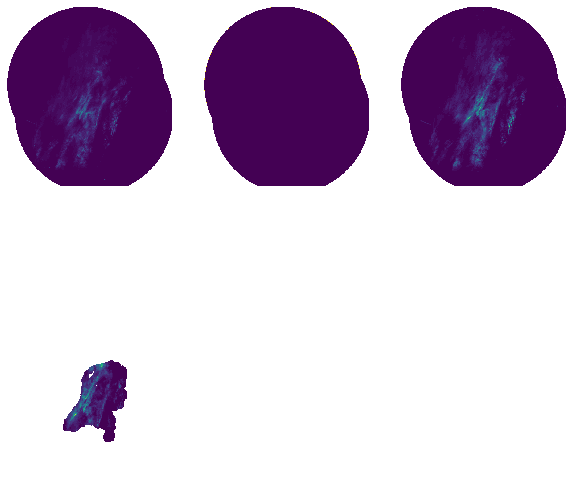

In [75]:
dt = datetime(year=2020, month=1,day=15,hour=14, minute=0)
d = create_ds(dt,x_size=3,y_size=1)

for element in d:
    x, y = element
    print(x.shape,y.shape)
    plotIO(x,y)

# Converting to Keras

The next step is to use the previous code to create a DataGenerator object in keras. This object can then yield samples on the fly during training. 

The code below is adapted from [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) and I am currently rewriting it to fit the current project

In [86]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, 
                 img_dim = (765, 700, 1), x_seq_size=3, y_seq_size=1, shuffle=True,
                x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar',
                y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart',
                normalize_y=True):
        'Initialization'
        self.inp_shape = (x_seq_size, *img_dim)
        self.out_shape = (y_seq_size, *img_dim)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()
        self.x_path = x_path
        self.y_path = y_path
        self.normalize_y = normalize_y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, *self.inp_shape))
        y = np.empty((self.batch_size, *self.out_shape))
        
        # Generate data
        for i, IDs in enumerate(list_IDs_temp):
            x_IDs, y_IDs = IDs
            
            # Store input image(s)
            for c in range(self.inp_shape[0]):
                X[i,c] = self.load_x(x_IDs[c])

            # Store target image(s)
            for c in range(self.out_shape[0]):
                y[i,c] = self.load_y(y_IDs[c])
        
        if self.normalize_y:
            y = self.zscore(y)
            
        return X, y
    
    def load_x(self, x_ID):
        path = self.x_path + '/RAD_NL25_RAC_RT_{}.h5'.format(x_ID)
        with h5py.File(path, 'r') as f:
            rain = f['image1']['image_data'][:]
            # set masked values to 0
            rain[rain == 65535] = 0
            # Expand dimensions from (w,h) to (w,h,c=1)
            rain = np.expand_dims(rain, axis=-1)
            return rain
        
    def load_y(self, y_ID):
        path = self.y_path + '/RAD_NL25_RAC_MFBS_EM_5min_{}.nc'.format(y_ID)

        with netCDF4.Dataset(path, 'r') as f:
            rain = f['image1_image_data'][:].data[0]
            # Convert to integers
            
            # set masked values to 0
            rain[rain > 65534] = 0
            # Expand dimensions from (w,h) to (w,h,c=1)
            rain = np.expand_dims(rain, axis=-1)
            
            return rain.data
        
    def zscore(self, x):
        MEAN = 0.7740296547051635
        STD = 37.88184326601481

        return (x-MEAN)/STD

In [77]:
# Create list of IDs to retrieve
x_seq_size=3
y_seq_size=1
# Create datetime object from start date till end date
start_dt = datetime(2020,1,15,14)
end_dt =  datetime(2020,1,15,16)
dts = np.arange( start_dt,
                end_dt, 
                timedelta(minutes=5*x_seq_size)).astype(datetime)
# Convert to filenames
list_IDs = [filenames_xy(dt,x_seq_size,y_seq_size) for dt in dts]
list_IDs 

[(['202001151345', '202001151350', '202001151355'], ['202001151400']),
 (['202001151400', '202001151405', '202001151410'], ['202001151415']),
 (['202001151415', '202001151420', '202001151425'], ['202001151430']),
 (['202001151430', '202001151435', '202001151440'], ['202001151445']),
 (['202001151445', '202001151450', '202001151455'], ['202001151500']),
 (['202001151500', '202001151505', '202001151510'], ['202001151515']),
 (['202001151515', '202001151520', '202001151525'], ['202001151530']),
 (['202001151530', '202001151535', '202001151540'], ['202001151545'])]

In [91]:
generator = DataGenerator(list_IDs, batch_size=2, x_seq_size=x_seq_size, y_seq_size=y_seq_size, normalize_y=False)

In [92]:
for i in generator:
    x,y = i
    print(x.shape, y.shape)
    print(np.unique(y))

(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)
[0.         0.01       0.02       0.03       0.04       0.05
 0.06       0.07       0.08       0.09       0.09999999 0.11
 0.12       0.13       0.14       0.14999999 0.16       0.17
 0.17999999 0.19       0.19999999 0.20999999 0.22       0.22999999
 0.23999999 0.25       0.25999999 0.26999998 0.28       0.28999999
 0.29999998 0.31       0.31999999 0.32999998 0.34       0.34999999
 0.35999998 0.37       0.38       0.38999999 0.39999998 0.41
 0.41999999 0.42999998 0.44       0.44999999 0.45999998 0.47
 0.47999999 0.48999998 0.5        0.50999999 0.51999998 0.52999997
 0.53999996 0.55000001 0.56       0.56999999 0.58999997 0.59999996
 0.61000001 0.62       0.63       0.63999999 0.65999997]
(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)
[0.         0.01       0.02       0.03       0.04       0.05
 0.06       0.07       0.08       0.09       0.09999999 0.11
 0.12       0.13       0.14       0.14999999 0.16       0.17
 0.17999999 0.19       0.19999999 0.2099

In [95]:
def get_list_IDs(start_dt, end_dt, x_seq_size=3, y_seq_size=1):
    dts = np.arange( start_dt,
                end_dt, 
                timedelta(minutes=5*x_seq_size)).astype(datetime)
    list_IDs = [filenames_xy(dt,x_seq_size,y_seq_size) for dt in dts]
    return list_IDs

# Test with simple model

In [28]:
mask = mask_y.astype(float)
mask = np.expand_dims(mask, axis=0)
mask = np.expand_dims(mask, axis=-1)
mask.shape

(1, 765, 700, 1)

In [29]:
def simple_model():
    input_seq = tf.keras.Input(shape=(3, 765, 700, 1))

    convLSTM = tf.keras.layers.ConvLSTM2D(filters=5, kernel_size=(2, 2), padding='same', return_sequences=True)(input_seq)
    
    convLSTM = tf.keras.layers.ConvLSTM2D(filters=1, kernel_size=(2, 2), padding='same', return_sequences=False, activation='tanh')(convLSTM)
    
    output = tf.keras.layers.Reshape(target_shape=(1,765, 700, 1))(convLSTM)
    
    output_with_mask = tf.keras.layers.Multiply()([output, mask])
    
    model = tf.keras.Model(inputs=input_seq, outputs=output_with_mask)
    return model

In [30]:
model = simple_model()
model.summary()
#plot_model(model)
model.compile( optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.MeanSquaredError()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 765, 700, 1)]  0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 765, 700, 5)    500       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 765, 700, 1)       100       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 765, 700, 1)    0         
_________________________________________________________________
multiply_1 (Multiply)        (None, 1, 765, 700, 1)    0         
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [253]:
start_dt = datetime(2020,1,1,0,0)
end_dt =  datetime(2020,1,1,23,55)
list_IDs = get_list_IDs(start_dt, end_dt)
print(len(list_IDs))
generator = DataGenerator(list_IDs, batch_size=32, x_seq_size=x_seq_size, y_seq_size=y_seq_size)

96


In [254]:
hist = model.fit(generator, epochs=3)

Epoch 1/3
3/3 [==============================] - 75s 25s/step - loss: 4.1756e-04 - mean_squared_error: 4.1756e-04
Epoch 2/3
3/3 [==============================] - 75s 25s/step - loss: 4.1731e-04 - mean_squared_error: 4.1731e-04
Epoch 3/3
3/3 [==============================] - 76s 25s/step - loss: 4.1705e-04 - mean_squared_error: 4.1705e-04


No handles with labels found to put in legend.


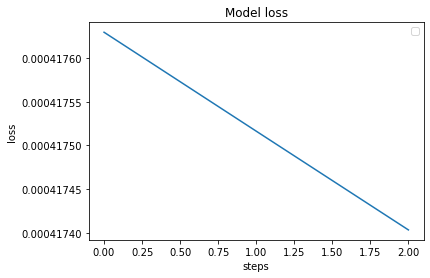

In [248]:
# Plot the training progress
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.legend()

In [213]:
for i in generator:
    x,y = i
    print(x.shape, y.shape)
    out = model(x)
    print(out.shape)

(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)
(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)
(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)
(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)
(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)
(16, 3, 765, 700, 1) (16, 1, 765, 700, 1)
(16, 1, 765, 700, 1)


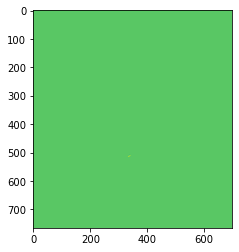

In [249]:
plt.imshow(np.squeeze(out[0][0]))

In [250]:
np.unique(np.squeeze(out[0][0]))

array([-8.4721200e-02, -6.9171600e-02, -4.2301215e-02, -3.3522390e-02,
       -2.9104324e-02, -2.7258858e-02, -2.6591785e-02, -2.0664036e-02,
       -1.7541679e-02, -1.4023152e-02, -1.3372022e-02, -1.3363854e-02,
       -1.0516284e-02, -6.5992703e-03, -5.0101541e-03, -3.0663304e-03,
       -2.8695241e-03, -2.7787664e-03, -2.3743883e-03, -2.3529890e-03,
       -2.1012649e-03, -1.5882867e-03, -1.5172173e-03, -1.0983186e-03,
       -1.0398692e-03, -6.8426743e-04, -5.0468172e-04, -3.9075292e-04,
       -2.0581168e-04, -1.7644421e-04, -1.5058518e-04, -1.4742823e-04,
       -8.0701699e-05, -5.4152359e-05, -1.3600593e-05,  0.0000000e+00,
        2.6464573e-07,  1.8301835e-05,  3.5304274e-05,  6.9237874e-05,
        7.9223420e-05,  9.0302441e-05,  9.0374677e-05,  1.2225297e-04,
        1.2914531e-04,  1.4169728e-04,  1.5415940e-04,  2.0658456e-04,
        2.8172109e-04,  3.2488728e-04,  3.2925449e-04,  3.7128935e-04,
        5.3470203e-04,  6.9532817e-04,  8.1541628e-04,  1.2406635e-03,
      

# Bigger model

Based upon the paper by Tian. Used convLSTM instead of ConvGRU as the latter is not available in keras. Plus reduced the number of layers

In [93]:
def bigger_model():
    input_seq = tf.keras.Input(shape=(3, 765, 700, 1))

    down = tf.keras.layers.Conv2D(filters=8, kernel_size=(7, 7), strides=(5,5), padding='same')(input_seq)
    down = tf.keras.layers.LeakyReLU()(down)
    
    convLSTM = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                                          strides=(1,1),
                                          padding='same', 
                                          return_sequences=True)(down)
    convLSTM = tf.keras.layers.LeakyReLU()(convLSTM)
    convLSTM = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), 
                                          strides=(1,1),
                                          padding='same', 
                                          return_sequences=False)(convLSTM)
    convLSTM = tf.keras.layers.LeakyReLU()(convLSTM)
    up = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(7, 7), 
                                         strides=(5,5), padding='same')(convLSTM)
    convLSTM = tf.keras.layers.LeakyReLU()(convLSTM)
    output = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), 
                                    strides=(1,1), padding='same', activation='sigmoid')(up)
    
    output = tf.keras.layers.Reshape(target_shape=(1,765, 700, 1))(output)
    model = tf.keras.Model(inputs=input_seq, outputs=output)
    return model

model = bigger_model()
model.summary()
#plot_model(model)
model.compile( optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.MeanSquaredError()])

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 3, 765, 700, 1)]  0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 153, 140, 8)    400       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 3, 153, 140, 8)    0         
_________________________________________________________________
conv_lst_m2d_44 (ConvLSTM2D) (None, 3, 153, 140, 64)   166144    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 3, 153, 140, 64)   0         
_________________________________________________________________
conv_lst_m2d_45 (ConvLSTM2D) (None, 153, 140, 64)      819456    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 153, 140, 64)      0  

In [96]:
start_dt = datetime(2020,1,1,0,0)
end_dt =  datetime(2020,1,1,23,55)
list_IDs = get_list_IDs(start_dt, end_dt)
print(len(list_IDs))
generator = DataGenerator(list_IDs, batch_size=32, x_seq_size=x_seq_size, y_seq_size=y_seq_size, normalize_y=False)

96


In [ ]:
hist = model.fit(generator, epochs=3)

Epoch 1/3
